In [3]:
import pyfits
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.io import fits
import scipy.ndimage as snd
%matplotlib inline


10
[945.0, 925.0, 950.0, 905.0, 985.0, 930.0, 915.0, 905.0, 910.0, 900.0]
[[2062 2025 2053 ..., 2055 2038 1981]
 [2181 2172 2098 ..., 2080 2058 2111]
 [2214 2154 2095 ..., 2122 2100 2080]
 ..., 
 [2109 2176 2090 ..., 2109 2111 2084]
 [2107 2119 2134 ..., 2171 2104 2109]
 [2094 2119 2115 ..., 2076 2107 2096]]


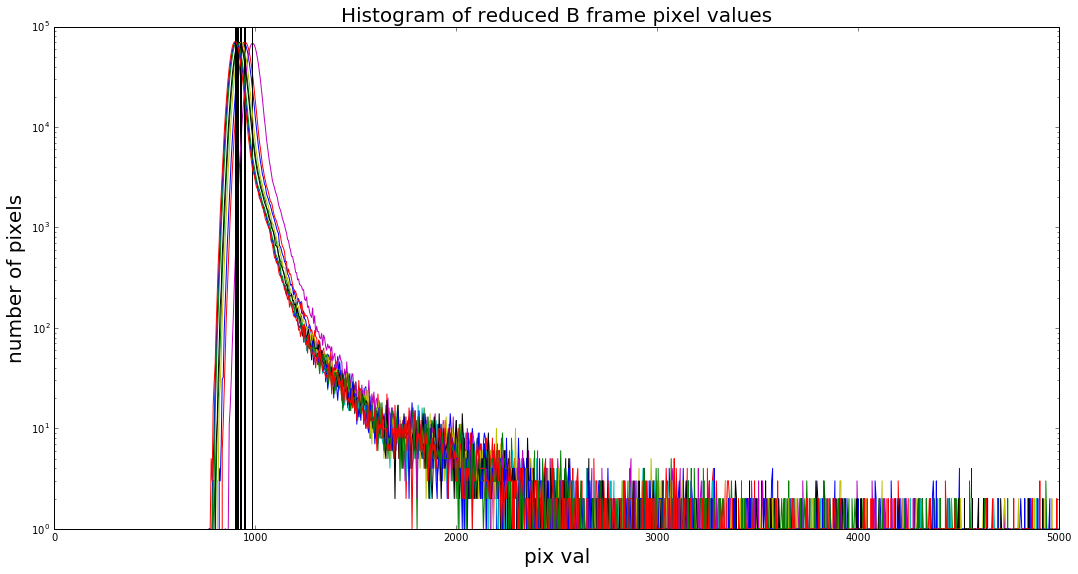

In [4]:
""""""""""""""""

Observing Data for 5/22/2012

Biases

Flats B Band

M51 B Band

"""""""""""""""""

bias_files=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-22-2012/bias/*.FIT')
biasfits = np.array([pyfits.getdata(filename) for filename in bias_files])

flat_B_files=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-22-2012/Flat_B/*.FIT')
flat_B_fits = np.array([pyfits.getdata(filename) for filename in flat_B_files])

M51_B_files=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-22-2012/M51_B_300s/*.FIT')
M51_B_fits = np.array([pyfits.getdata(filename) for filename in M51_B_files])

medianbias = np.median(biasfits, axis=0)
medianflat_B = np.median(flat_B_fits, axis=0)

#combined_flat_B=np.sum(flat_B_fits,axis=0)-medianbias
#normailized_combined_flat_B=combined_flat_B/np.median(combined_flat_B)

#reduced_flat=medianflat_B-medianbias


def reduce_raw_science_frames(M51_B_fits,medianbias,medianflat_B):
    allreducedimgs=[]
    normed_flat=(medianflat_B-medianbias)/np.median(medianflat_B-medianbias)
    for i in range(len(M51_B_fits)): 
        reduced_frame=(M51_B_fits[i]-medianbias)/normed_flat
        allreducedimgs.append(reduced_frame)
    allreducedimgs=np.array(allreducedimgs)
    return allreducedimgs

science_reduced_B = reduce_raw_science_frames(M51_B_fits,medianbias,medianflat_B)

print len(science_reduced_B)

plt.figure(figsize=(18,9))
skylevels=[]
for i in range(len(science_reduced_B)):
    numpix,aduvals=np.histogram(science_reduced_B[i].flatten(),bins=1000,range=[0,5e3])
    skylevel=aduvals[np.where(numpix==numpix.max())][0]
    skylevels.append(skylevel)
    plt.plot(aduvals[:-1],numpix)
    plt.axvline(skylevel,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')

print skylevels
plt.title('Histogram of reduced B frame pixel values',fontsize=20)


""""hdu = fits.PrimaryHDU(reduced_flat)
hdulist = fits.HDUList([hdu])
#hdulist.writeto('new.fits')

reduced_science=(M51_B_fits-medianbias)/reduced_flat

print len(reduced_science)

hdu1 = fits.PrimaryHDU(reduced_science[0])
hdulist = fits.HDUList([hdu1])
hdulist.writeto('new2.fits')

#plt.imshow(medianflat)
"""
print M51_B_fits[0]

In [7]:
print(aduvals)

[    0.     5.    10. ...,  4990.  4995.  5000.]


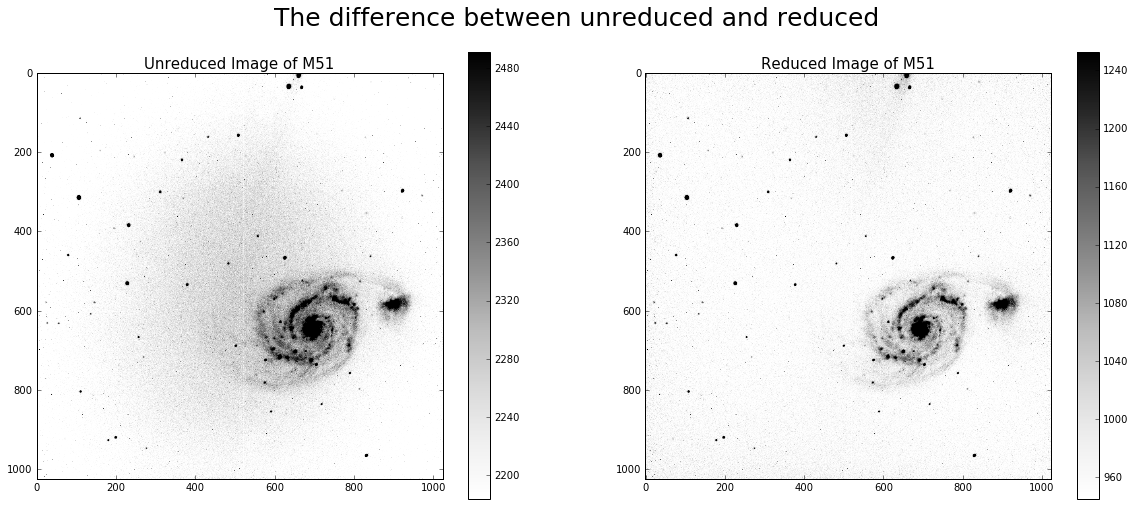

In [8]:
testnum=0
nstd=10
#unreduced=pyfits.getdata(science_filenames[testnum])
plt.figure(figsize=(20,8))
plt.subplot(121)
vmin_unred=np.median(medianbias)+skylevels[testnum]
x=np.max(M51_B_fits[0])+np.sqrt(M51_B_fits[0])
plt.imshow(M51_B_fits[0],cmap='Greys',vmin=vmin_unred,vmax=vmin_unred+nstd*np.sqrt(skylevels[testnum]))
plt.title("Unreduced Image of M51",fontsize=15)
plt.colorbar()
plt.subplot(122)
plt.imshow(science_reduced_B[testnum],cmap='Greys',vmin=skylevels[testnum],vmax=skylevels[testnum]+nstd*np.sqrt(skylevels[testnum]))
plt.title("Reduced Image of M51",fontsize=15)
plt.colorbar()
plt.suptitle('The difference between unreduced and reduced',fontsize=25)

In [5]:
plt.imshow?

In [249]:
def find_object_centroids_filterbysize(img,threshold,minsize):
    labels, num = snd.label(img > threshold, np.ones((3,3)))     # scipy labels/segments the image using a threshold
    centers = snd.center_of_mass(img, labels, range(1,num+1))    # scipy calculates the center of mass on the labeled img
    x = np.array(centers)[:,1]
    y = np.array(centers)[:,0]
    slices=snd.find_objects(labels)
    xs=np.array([objlabel[1].stop-objlabel[1].start for objlabel in slices])  # takes the min and max label slices
    ys=np.array([objlabel[0].stop-objlabel[0].start for objlabel in slices])  #  to find a rough object size

    maxsize=20    # I hardcoded this in so that some spurious objects would be skipped. Change/delete if you like
    bigenough=np.where((xs>minsize) & (ys>minsize) & (xs<maxsize) & (ys<maxsize))
    xc,yc=x[bigenough],y[bigenough]
    xs,ys=xs[bigenough],ys[bigenough]
    
    print str(len(xc))+' objects found'
    return xc,yc,xs,ys

80 objects found


[0, 1024, 0, 1024]

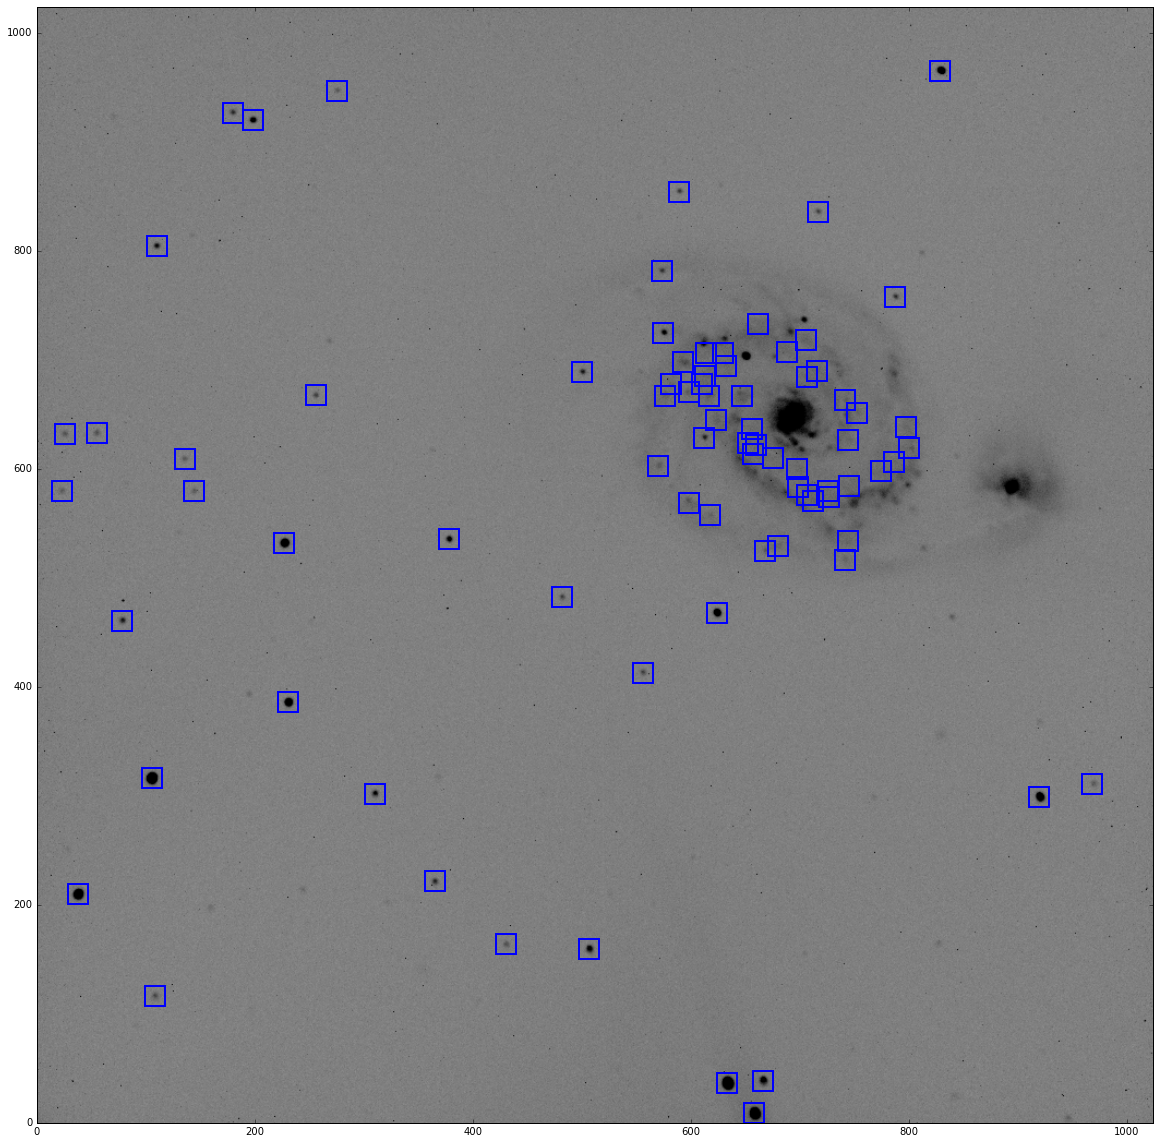

In [250]:
imgnum=0
nstd_aboveskynoise=5
threshold=skylevels[imgnum]+nstd_aboveskynoise*np.sqrt(skylevels[imgnum])   # decide on a threshold using the sky noise
minsize=3

xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced_B[imgnum],threshold,minsize)


plt.figure(figsize=(20,20))
plt.imshow(science_reduced_B[imgnum],cmap='Greys',vmin=0,vmax=1.5*threshold)
plt.plot(xfoo,yfoo,'rs',mfc='None',markersize=20,markeredgecolor='b',markeredgewidth=2)
plt.axis([0,1024,0,1024])



In [251]:
stackedimg=np.median(science_reduced_B,axis=0)-np.median(skylevels)
pyfits.writeto('/Users/noahknoblauch/PHY157/Observing/Stacked_B.FITS',stackedimg,clobber=True)

82 objects found
84 objects found
83 objects found
79 objects found
87 objects found
92 objects found
87 objects found
85 objects found
87 objects found
90 objects found


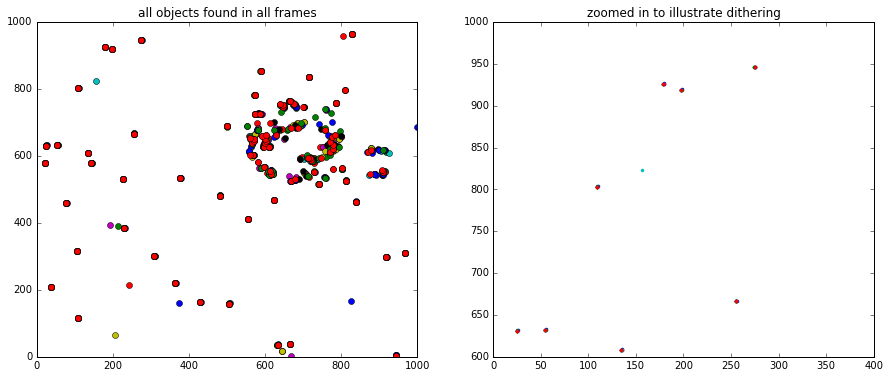

In [252]:
nstd_aboveskynoise=4
thresholds=skylevels+nstd_aboveskynoise*np.sqrt(skylevels)

#thresholds=[threshold]*len(science_reduced)
minsize=3
xc_all,yc_all,xs_all,ys_all=[],[],[],[]
plt.figure(figsize=(15,6))
for i in range(len(science_reduced_B)):
    xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced_B[i],thresholds[i],minsize)
    xc_all.append(xfoo)
    yc_all.append(yfoo)
    xs_all.append(xsfoo)
    ys_all.append(ysfoo)
    plt.subplot(121)
    plt.plot(xfoo,yfoo,'o')
    plt.subplot(122)
    plt.plot(xfoo,yfoo,'.')
    plt.axis([0,400,600,1000])
plt.subplot(121)
plt.title('all objects found in all frames')
plt.subplot(122)
plt.title('zoomed in to illustrate dithering')

10
[2725.0, 2755.0, 2760.0, 2755.0, 2760.0, 2765.0, 2790.0, 2800.0, 2795.0, 2800.0]


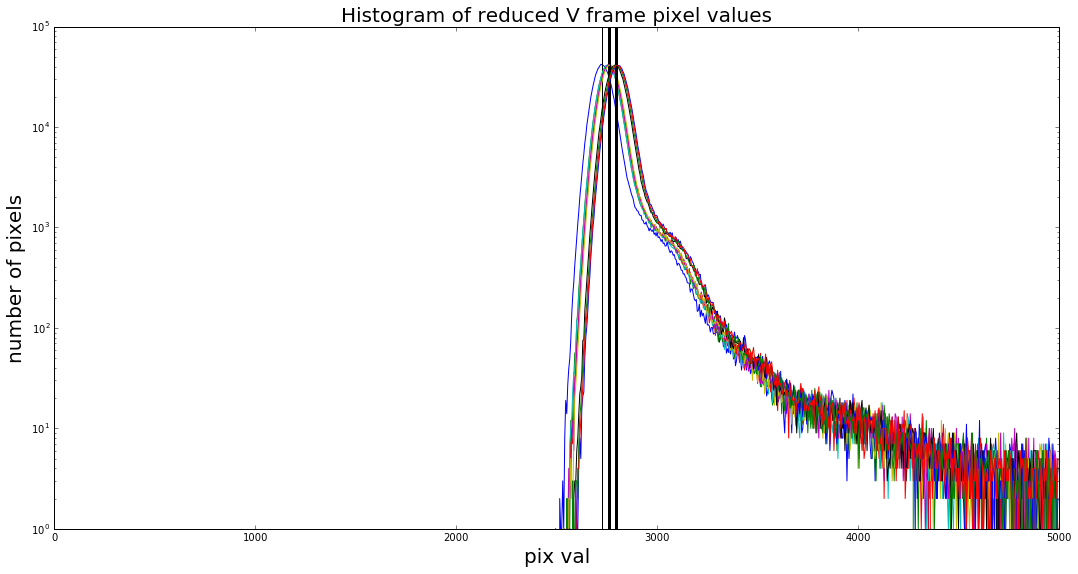

In [253]:
"""""""""
Observing Data for 5/22/2012

Flats V Band

M51 V Band
"""""""""
flat_V_files=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-22-2012/Flat_V/*.FIT')
flat_V_fits = np.array([pyfits.getdata(filename) for filename in flat_V_files])

M51_V_files=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-22-2012/M51_V_300s/*.FIT')
M51_V_fits = np.array([pyfits.getdata(filename) for filename in M51_V_files])

medianflat_V = np.median(flat_V_fits, axis=0)

#plt.imshow(medianflat_V)

science_reduced_V = reduce_raw_science_frames(M51_V_fits,medianbias,medianflat_V)

print len(science_reduced_V)

plt.figure(figsize=(18,9))
skylevels1=[]
for i in range(len(science_reduced_V)):
    numpix1,aduvals1=np.histogram(science_reduced_V[i].flatten(),bins=1000,range=[0,5e3])
    skylevel1=aduvals1[np.where(numpix1==numpix1.max())][0]
    skylevels1.append(skylevel1)
    plt.plot(aduvals1[:-1],numpix1)
    plt.axvline(skylevel1,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')

print skylevels1
plt.title('Histogram of reduced V frame pixel values',fontsize=20)


80 objects found


[0, 1024, 0, 1024]

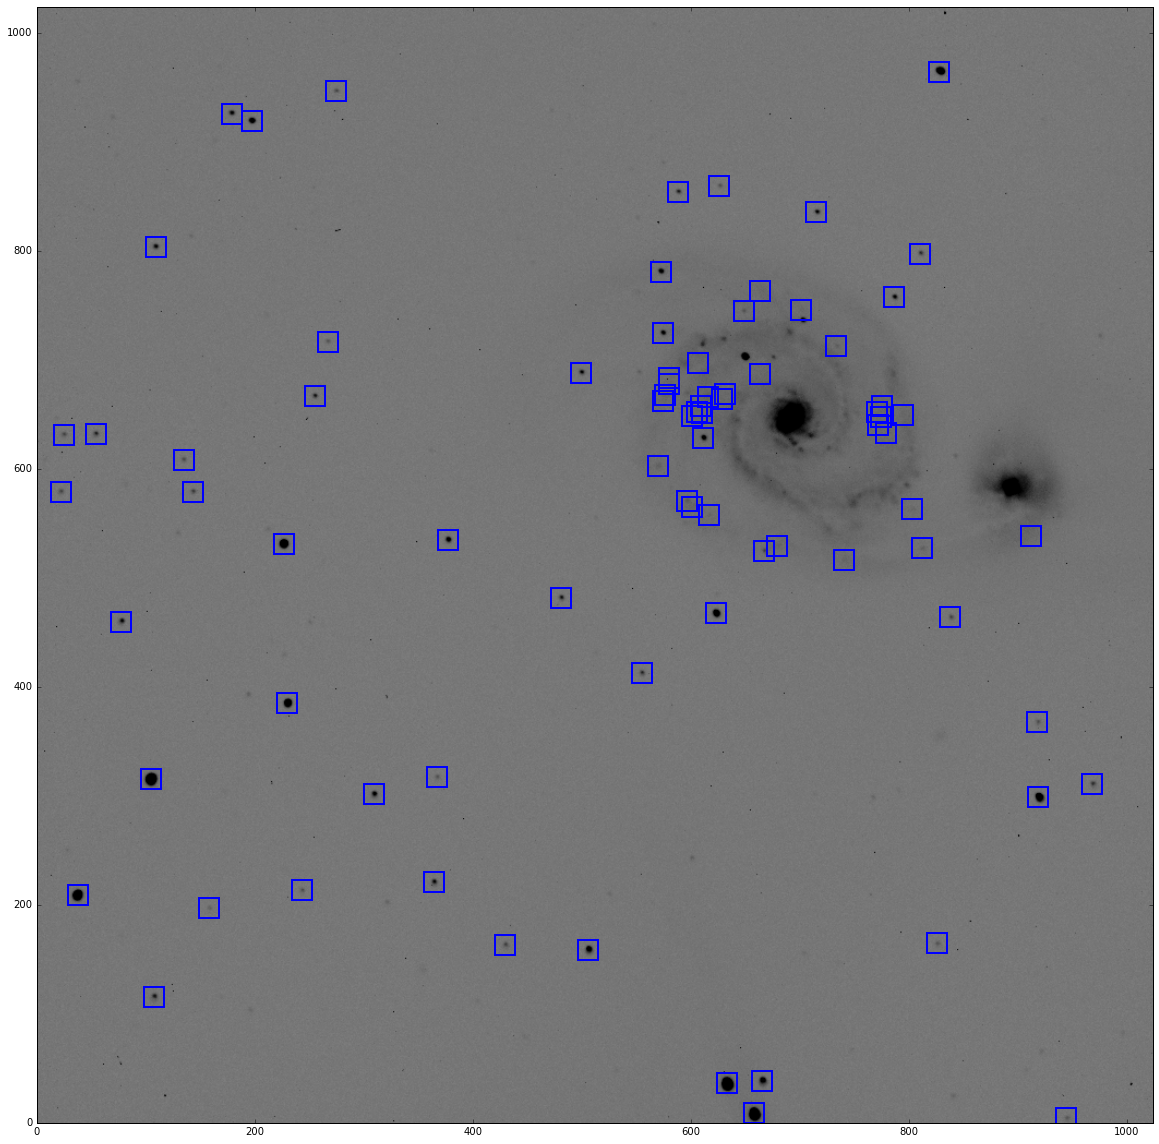

In [254]:
imgnum1=0
nstd_aboveskynoise1=5
threshold1=skylevels1[imgnum1]+nstd_aboveskynoise1*np.sqrt(skylevels1[imgnum1])   # decide on a threshold using the sky noise
minsize=3

xfoo1,yfoo1,xsfoo1,ysfoo1=find_object_centroids_filterbysize(science_reduced_V[imgnum1],threshold1,minsize)


plt.figure(figsize=(20,20))
plt.imshow(science_reduced_V[imgnum1],cmap='Greys',vmin=0,vmax=1.5*threshold1)
plt.plot(xfoo1,yfoo1,'rs',mfc='None',markersize=20,markeredgecolor='b',markeredgewidth=2)
plt.axis([0,1024,0,1024])

87 objects found
82 objects found
98 objects found
92 objects found
94 objects found
90 objects found
82 objects found
91 objects found
95 objects found
93 objects found


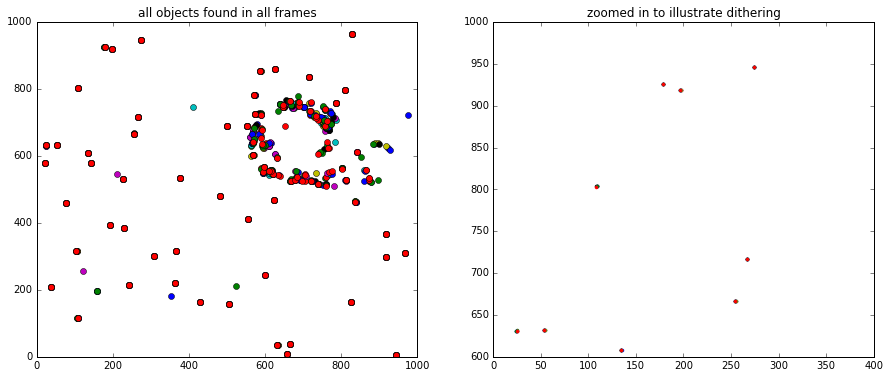

In [255]:
nstd_aboveskynoise=4
thresholds1=skylevels1+nstd_aboveskynoise*np.sqrt(skylevels1)

#thresholds=[threshold]*len(science_reduced)
minsize=3
xc_all1,yc_all1,xs_all1,ys_all1=[],[],[],[]
plt.figure(figsize=(15,6))
for i in range(len(science_reduced_V)):
    xfoo1,yfoo1,xsfoo1,ysfoo1=find_object_centroids_filterbysize(science_reduced_V[i],thresholds1[i],minsize)
    yc_all1.append(yfoo1)
    xs_all1.append(xsfoo1)
    ys_all1.append(ysfoo1)
    plt.subplot(121)
    plt.plot(xfoo1,yfoo1,'o')
    plt.subplot(122)
    plt.plot(xfoo1,yfoo1,'.')
    plt.axis([0,400,600,1000])
plt.subplot(121)
plt.title('all objects found in all frames')
plt.subplot(122)
plt.title('zoomed in to illustrate dithering')

In [256]:
""""""""""""""""

Observing Data for 5/22/2012

Biases

Flats I Band

M51 I Band

"""""""""""""""""

flat_I_files=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-24-2012/Flat_I/*.FIT')
flat_I_fits = np.array([pyfits.getdata(filename) for filename in flat_I_files])

M51_I_files=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-24-2012/M51_I/M51/*.FIT')
M51_I_fits = np.array([pyfits.getdata(filename) for filename in M51_I_files])

bias_files_522=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-24-2012/bias/*.FIT')
biasfits_524 = np.array([pyfits.getdata(filename) for filename in bias_files])


medianflat_I = np.median(flat_I_fits, axis=0)
medianbias_524=np.median(biasfits_524, axis=0)

science_reduced_I = reduce_raw_science_frames(M51_I_fits,medianbias_524,medianflat_I)

print len(science_reduced_I)

#print len(medianflat_I[0])
#print len(M51_I_fits[0])

10


[620.0, 625.0, 635.0, 635.0, 650.0, 645.0, 650.0, 660.0, 690.0, 670.0]


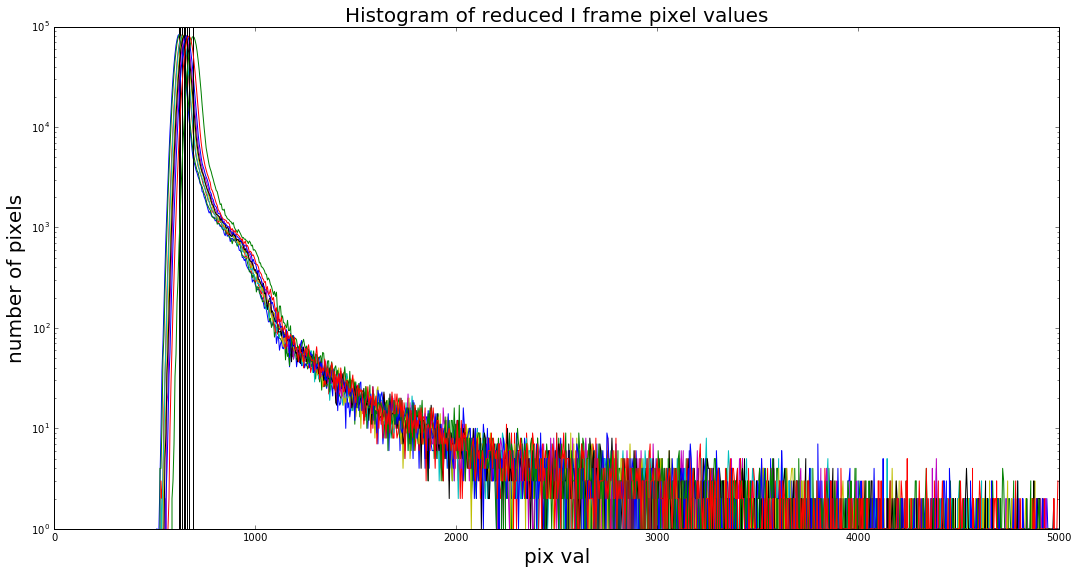

In [257]:
plt.figure(figsize=(18,9))
skylevels_I=[]
for i in range(len(science_reduced_I)):
    numpix_I,aduvals_I=np.histogram(science_reduced_I[i].flatten(),bins=1000,range=[0,5e3])
    skylevel_I=aduvals_I[np.where(numpix_I==numpix_I.max())][0]
    skylevels_I.append(skylevel_I)
    plt.plot(aduvals_I[:-1],numpix_I)
    plt.axvline(skylevel_I,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')

print skylevels_I
plt.title('Histogram of reduced I frame pixel values',fontsize=20)


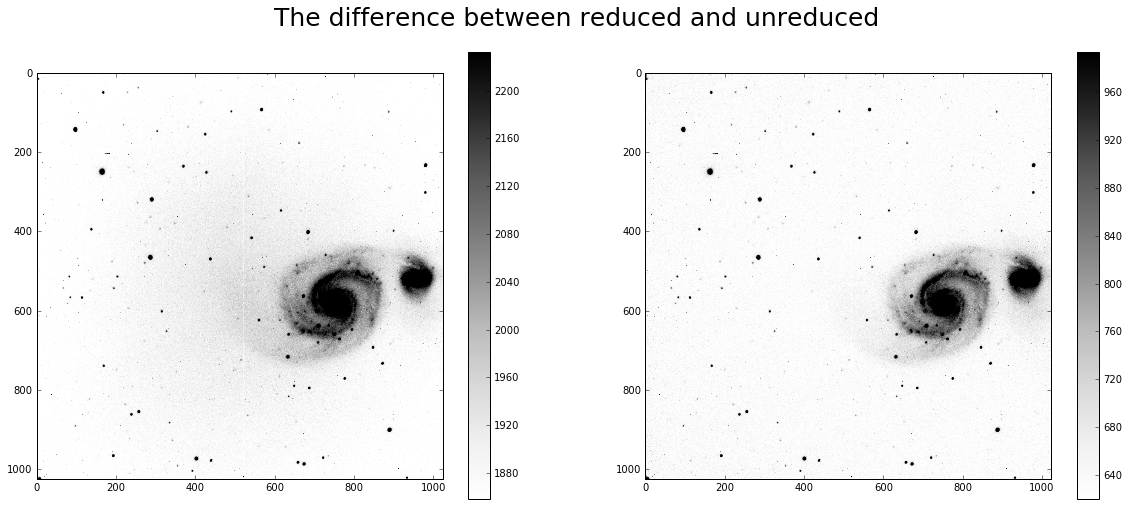

In [258]:
# testnum=0
nstd=15
#unreduced=pyfits.getdata(science_filenames[testnum])
plt.figure(figsize=(20,8))
plt.subplot(121)
vmin_unred_I=np.median(medianbias_524)+skylevels_I[testnum]
x=np.max(M51_I_fits[0])+np.sqrt(M51_I_fits[0])
plt.imshow(M51_I_fits[0],cmap='Greys',vmin=vmin_unred_I,vmax=vmin_unred_I+nstd*np.sqrt(skylevels_I[testnum]))
plt.colorbar()
plt.subplot(122)
plt.imshow(science_reduced_I[testnum],cmap='Greys',vmin=skylevels_I[testnum],vmax=skylevels_I[testnum]+nstd*np.sqrt(skylevels_I[testnum]))
plt.colorbar()
plt.suptitle('The difference between reduced and unreduced',fontsize=25)

[243.0, 237.0, 258.0, 258.0, 228.0, 225.0, 219.0, 216.0, 213.0, 210.0, 207.0, 207.0, 207.0, 204.0]


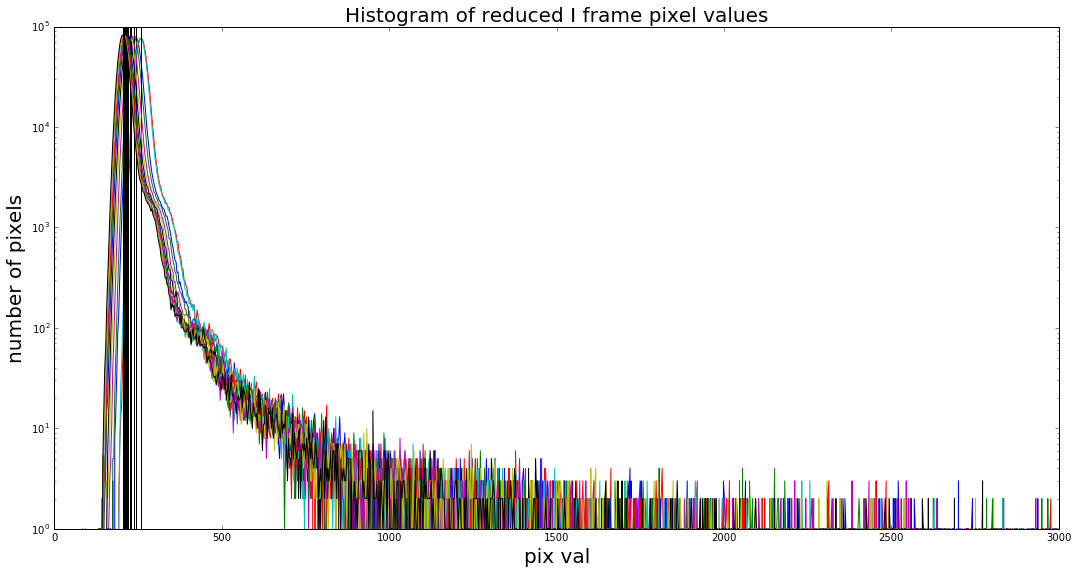

In [259]:
M51_Ha_files_529=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-29-2012/M51_Ha/*.FIT')
M51_Ha_fits_529 = np.array([pyfits.getdata(filename) for filename in M51_Ha_files_529])

M51_Ha_files_531=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-31-2012/M51_Ha/*.FIT')
M51_Ha_fits_531 = np.array([pyfits.getdata(filename) for filename in M51_Ha_files_531])

bias_files_529 =glob.glob('/Users/noahknoblauch/PHY157/Observing/5-29-2012/bias/*.FIT')
biasfits_529 = np.array([pyfits.getdata(filename) for filename in bias_files_529])

bias_files_531 =glob.glob('/Users/noahknoblauch/PHY157/Observing/5-31-2012/bias/*.FIT')
biasfits_531 = np.array([pyfits.getdata(filename) for filename in bias_files_531])

flat_Ha_files_529=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-29-2012/Ha_Flats/*.FIT')
flat_Ha_fits_529 = np.array([pyfits.getdata(filename) for filename in flat_Ha_files_529])

flat_Ha_files_531=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-31-2012/Ha_Flats/*.FIT')
flat_Ha_fits_531 = np.array([pyfits.getdata(filename) for filename in flat_Ha_files_531])

medianbias_529 = np.median(biasfits_529, axis=0)
medianbias_531 = np.median(biasfits_531, axis=0)
medianflat_Ha_529 = np.median(flat_Ha_fits_529, axis=0)
medianflat_Ha_531 = np.median(flat_Ha_fits_531, axis=0)



science_reduced_Ha_529 = reduce_raw_science_frames(M51_Ha_fits_529,medianbias_529,medianflat_Ha_529)

plt.figure(figsize=(18,9))
skylevels_Ha=[]
for i in range(len(science_reduced_Ha_529)):
    numpix_Ha,aduvals_Ha=np.histogram(science_reduced_Ha_529[i].flatten(),bins=1000,range=[0,3000])
    skylevel_Ha=aduvals_Ha[np.where(numpix_Ha==numpix_Ha.max())][0]
    skylevels_Ha.append(skylevel_Ha)
    plt.plot(aduvals_Ha[:-1],numpix_Ha)
    plt.axvline(skylevel_Ha,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')

print skylevels_Ha
plt.title('Histogram of reduced I frame pixel values',fontsize=20)



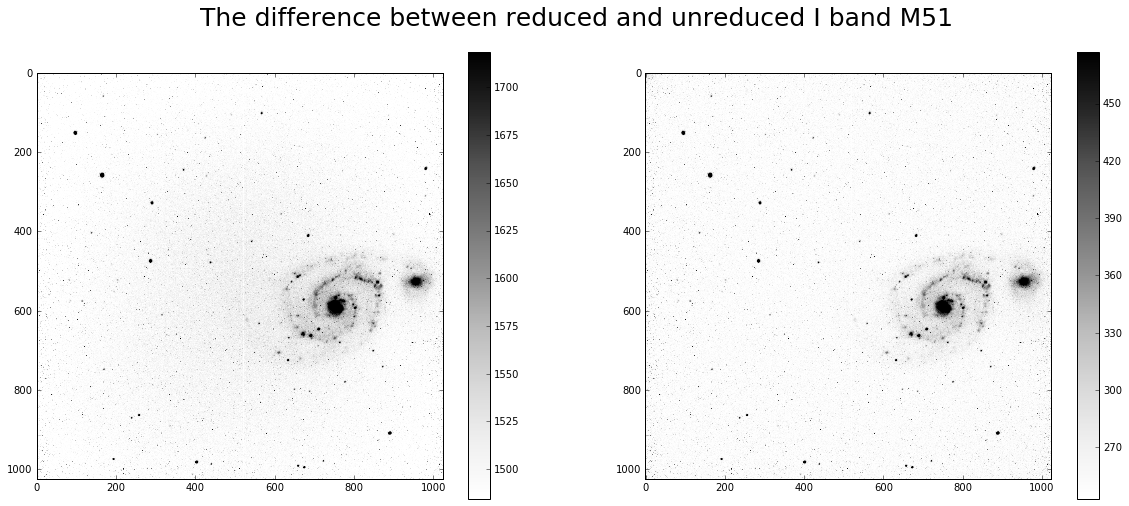

In [260]:
nstd=15
#unreduced=pyfits.getdata(science_filenames[testnum])
plt.figure(figsize=(20,8))
plt.subplot(121)
vmin_unred_Ha=np.median(medianbias_529)+skylevels_Ha[testnum]
x=np.max(M51_Ha_fits_529[0])+np.sqrt(M51_Ha_fits_529[0])
plt.imshow(M51_Ha_fits_529[0],cmap='Greys',vmin=vmin_unred_Ha,vmax=vmin_unred_Ha+nstd*np.sqrt(skylevels_Ha[testnum]))
plt.colorbar()
plt.subplot(122)
plt.imshow(science_reduced_Ha_529[testnum],cmap='Greys',vmin=skylevels_Ha[testnum],vmax=skylevels_Ha[testnum]+nstd*np.sqrt(skylevels_Ha[testnum]))
plt.colorbar()
plt.suptitle('The difference between reduced and unreduced I band M51',fontsize=25)

# V band calibration

10
[[ 4774.   4797.   4812.  ...,  4833.5  4883.5  4795.5]
 [ 5182.5  5299.   5248.  ...,  5350.   5349.   5299.5]
 [ 5213.5  5259.5  5275.5 ...,  5324.   5313.   5258.5]
 ..., 
 [ 5311.   5358.   5413.5 ...,  5478.5  5448.5  5385.5]
 [ 5292.5  5406.5  5402.5 ...,  5461.   5476.5  5400.5]
 [ 5314.5  5377.   5295.5 ...,  5471.5  5454.   5402.5]]


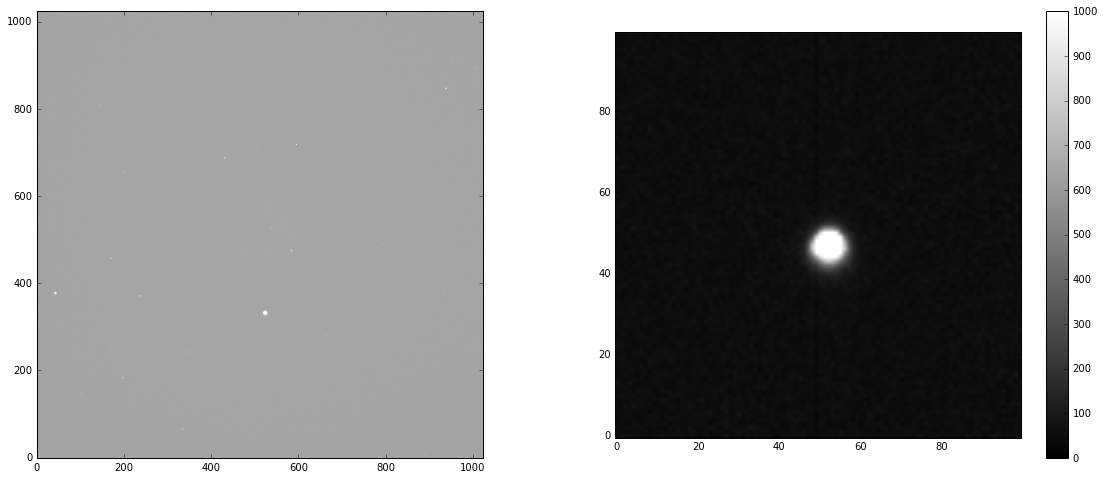

In [261]:
calibfilename=['/Users/noahknoblauch/PHY157/Observing/5-29-2012/107-544 Calibration 2 Ha B V/V 5 seconds 2.FIT']

flat_V_files_529=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-29-2012/V Flats/*.FIT')
flat_V_fits_529=np.array([pyfits.getdata(filename) for filename in flat_V_files_529])

print len(flat_V_fits_529)

calib_data=np.array(pyfits.getdata(calibfilename[0]))

medianflat_V_529=np.median(flat_V_fits_529, axis=0)
normed_flat_calib=(medianflat_V_529-medianbias_529)/np.median(medianflat_V_529-medianbias_529)
red_calibdata=(calib_data-medianbias_529)/normed_flat_calib

print medianflat_V_529

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(calib_data,vmin=0,vmax=2000,cmap='gray',origin='lower')
cal_snip=red_calibdata[285:385,470:570]
plt.subplot(122)
plt.imshow(cal_snip,vmin=0,vmax=1000,cmap='gray',origin='lower')
plt.colorbar()

58.5021143799 37.7757655032


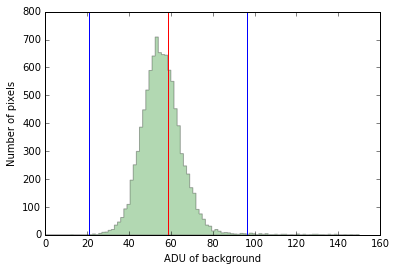

In [262]:
plt.hist(cal_snip.flatten(),bins=100,range=[0,150],histtype='stepfilled',color='g',alpha=.3)
plt.xlabel('ADU of background')
plt.ylabel('Number of pixels')
m,s=np.mean(cal_snip[cal_snip<1000]),np.std(cal_snip[cal_snip<1000])
plt.axvline(m-s),plt.axvline(m+s),plt.axvline(m,color='r')
print m,s

In [263]:
xc,yc=0,0
pixsum=0
nx,ny=np.shape(cal_snip)
for i in range(nx):
    for j in range(ny):
        if cal_snip[j,i]>6000:
            xc+=cal_snip[j,i]*i
            yc+=cal_snip[j,i]*j
            pixsum+=cal_snip[j,i]
xc,yc=xc/pixsum,yc/pixsum
print xc,yc

52.0344031909 47.5016697233


[25, 80, 30, 80]

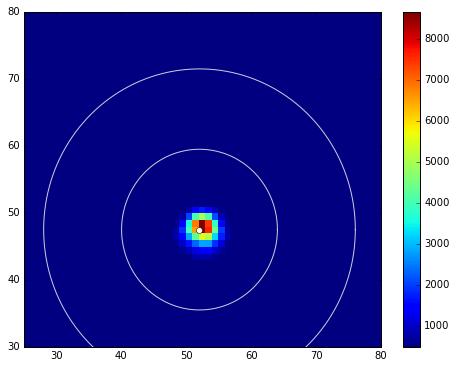

In [264]:
dr=12
r=np.arange(0,30,dr)
phi=np.linspace(0,2*np.pi,1000)


plt.figure(figsize=(8,6))
plt.pcolor(cal_snip,vmin=500)
plt.colorbar()
plt.plot(xc,yc,'wo')
for i in range(len(r)): plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'w',alpha=.8)
plt.axis([25,80,30,80])

In [265]:
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):
                ann_flux[k]+=cal_snip[j,i]
                ann_npix[k]+=1


print r,ann_flux-ann_npix*m,(ann_flux-m*ann_npix)/ann_npix


[ 0 12 24] [ 164168.63082841   -3486.38476882   -8059.1869488 ] [ 361.60491372   -2.56729364   -3.55971155]


In [266]:
cal_vflux=ann_flux[0]-ann_npix[0]*m
exposure=5
cal_airmass=1.285603458823
cal_mag_ext=.15*cal_airmass

print "Exposure time is: "+ str(exposure)
print "Flux is: " +str(cal_vflux)

cal_vmag=-2.5*np.log10(cal_vflux/exposure)
print "Instrumental magnitude is, -2.5*log10(flux/time): " + str(cal_vmag)

cal_mag_ext=.15*cal_airmass
print "The airmass is: " +str(cal_airmass)+", so given .15 magnitudes/airmass extinction, there are: " +str(cal_mag_ext)
print " magnitudes of extincion."

cal_vmag0=cal_vmag+cal_mag_ext
print "So our final instrum. magnitude in V, removing atmospheric effects, is: " +str(cal_vmag0)


landolt_vmag=9.036
cal_vzpt=landolt_vmag-cal_vmag0
print "Landolt says SA 107-544 is magnitude 9.036, so our zeropoint is then: " +str(cal_vzpt)

Exposure time is: 5
Flux is: 164168.630828
Instrumental magnitude is, -2.5*log10(flux/time): -11.2908004296
The airmass is: 1.28560345882, so given .15 magnitudes/airmass extinction, there are: 0.192840518823
 magnitudes of extincion.
So our final instrum. magnitude in V, removing atmospheric effects, is: -11.0979599108
Landolt says SA 107-544 is magnitude 9.036, so our zeropoint is then: 20.1339599108


[490, 890, 450, 850]

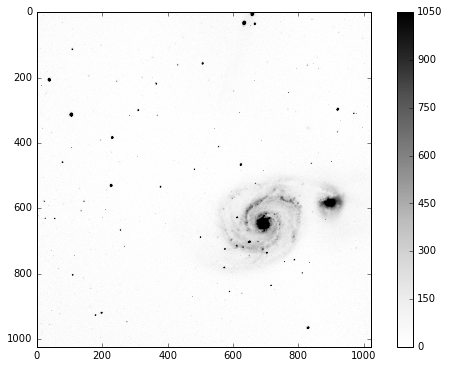

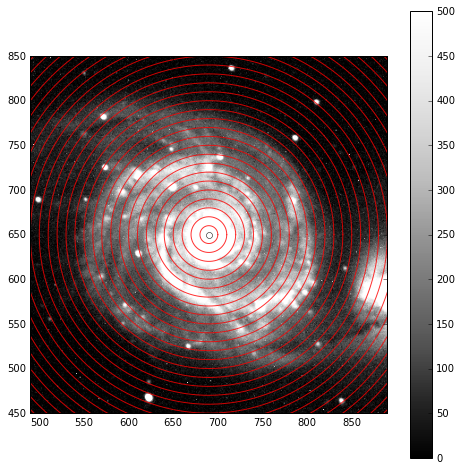

In [267]:
stackedimg=np.median(science_reduced_V,axis=0)-np.median(skylevels1)
plt.figure(figsize=(9,6))
plt.imshow(stackedimg,cmap='Greys',vmin=0,vmax=20*np.sqrt(np.median(skylevels1)))
plt.colorbar()

dr=10
r=np.arange(0,300,dr)
phi=np.linspace(0,2*np.pi,1000)
xc,yc=690,650

plt.figure(figsize=(8,8))
#m51_vsnip=stackedimg[500:850,400:750]
plt.imshow(stackedimg,vmin=0,vmax=.5e3,cmap='Greys_r')
plt.colorbar()

plt.plot(xc,yc,'wo')
for i in range(len(r)): plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'r',alpha=.8)
plt.axis([xc-200,xc+200,yc-200,yc+200])

14.7260662662
boobs


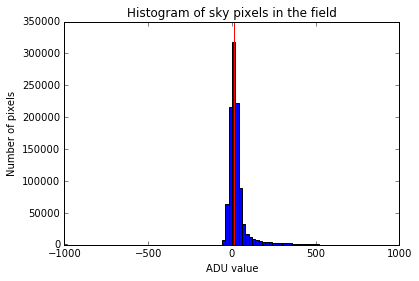

In [268]:
plt.hist(stackedimg.flatten(),range=[-1000,1000],bins=100)
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')
plt.title('Histogram of sky pixels in the field')
bkg=np.median(stackedimg)
plt.axvline(bkg,color='r')
print bkg

print"boobs"

In [269]:
nx,ny=np.shape(stackedimg)
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
# this loops over every pixel in the image (which is a rather brute force method)
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):     # if the pixel is insize the kth aperture, add it to the tally
                ann_flux[k]+=stackedimg[j,i]
                ann_npix[k]+=1


print r,ann_flux-bkg*ann_npix,(ann_flux-bkg*ann_npix)/ann_npix

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290] [  1.09723135e+06   1.30164354e+06   9.51986699e+05   8.52992330e+05
   9.21659688e+05   1.05641964e+06   1.42073890e+06   1.24893599e+06
   1.30339284e+06   1.23313912e+06   1.29707842e+06   1.29031585e+06
   1.07836505e+06   7.82797497e+05   5.63509891e+05   3.68528702e+05
   3.08332785e+05   3.79721082e+05   4.42234567e+05   6.75351570e+05
   6.44465203e+05   1.28126056e+06   6.98341795e+05   5.36234835e+05
   4.34962470e+05   2.53429634e+05   1.44080913e+05   1.10098931e+05
   2.56929192e+04  -2.43790675e+02] [  3.60931366e+03   1.40263312e+03   6.13393492e+02   3.89138837e+02
   3.29164174e+02   3.07814580e+02   3.48904446e+02   2.65957408e+02
   2.43533790e+02   2.07180632e+02   1.97966792e+02   1.78417567e+02
   1.37968916e+02   9.27485186e+01   6.17071716e+01   3.80397092e+01
   2.97388874e+01   3.46208135e+01   3.81499799e+01   5.51757818e+01
   5.00983522

In [270]:
m51_V_airmass=1.028792897739
pixscale=24*60/1024.
print "The pixel scale is: "+str(pixscale)+ ", airmass is: " + str(m51_V_airmass)

v_surfbright=-2.5*np.log10((ann_flux-bkg*ann_npix)/300.)+2.5*np.log10(ann_npix*pixscale**2)+cal_vzpt+.15*m51_V_airmass

The pixel scale is: 1.40625, airmass is: 1.02879289774


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


In [271]:
total_flux=(sum(ann_flux[0:30]-bkg*ann_npix[0:30]))


poisson=np.sqrt(total_flux)


mag=-2.5*np.log10(total_flux/300)+0.15*cal_airmass+cal_vzpt-0.037

mag_dust=mag-.079
print "Magnitude of M51:", mag

flux_jansk=3631*np.power(10,(mag/-2.5))

print "Flux in janskys:", flux_jansk

c=3e8
f_width=(c/490e-9)-(c/650e-9)

radius_M51=7100
radius_cm=23*9.461e23

Lum_ergs=4*np.pi*radius_cm**2*f_width*flux_jansk*1e-23

Lum_sun=3.8e33

Num_stars=Lum_ergs/Lum_sun

print Lum_ergs

print "Number of stars:",Num_stars

Magnitude of M51: 8.09240983985
Flux in janskys: 2.10408031349
1.88683417918e+43
Number of stars: 4965353103.09


In [272]:
print v_surfbright

[ 18.3278331   19.35403443  20.25204675  20.74613322  20.92786326
  21.00067169  20.8646284   21.15936443  21.25499659  21.43052178
  21.4799138   21.59280063  21.87194153  22.30312721  22.74555556
  23.27080169  23.53808287  23.37305149  23.26765887  22.86702342
  22.97183606  22.27781369  22.99072138  23.31600496  23.59237362
  24.22205112  24.87567187  25.20979048  26.82899361          nan]


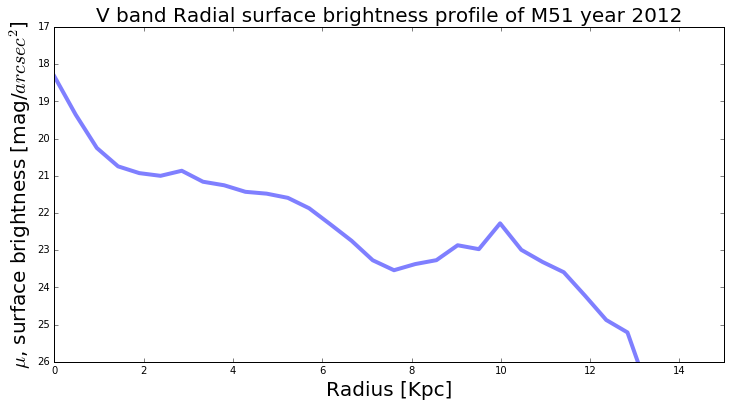

In [273]:
radius=r*pixscale*7100*(1/2.1e5)

plt.figure(figsize=(12,6))
plt.plot(radius,v_surfbright,linewidth=4,alpha=.5)
plt.axis([0,15,26,17])
plt.xlabel('Radius [Kpc]',fontsize=20)
plt.ylabel('$\\mu$, surface brightness [mag/$arcsec^2$]',fontsize=20)
plt.title('V band Radial surface brightness profile of M51 year 2012',fontsize=20)

# B Band calibration Star

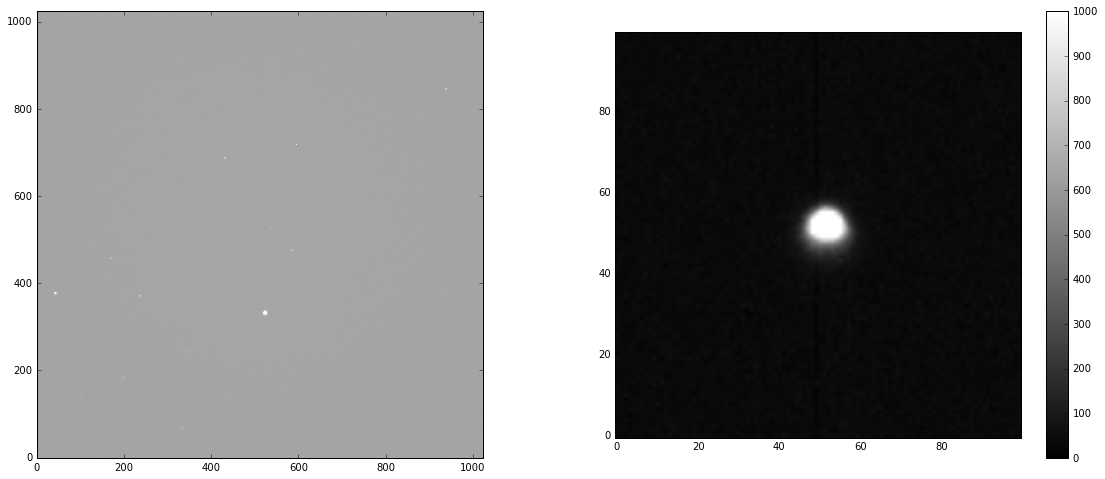

In [274]:
calibfilename_B=['/Users/noahknoblauch/PHY157/Observing/5-29-2012/107-544 Calibration 2 Ha B V/B 10 seconds 1.FIT']

calib_B_data=np.array(pyfits.getdata(calibfilename_B[0]))

flat_B_files_529=glob.glob('/Users/noahknoblauch/PHY157/Observing/5-29-2012/B Flats/*.FIT')
flat_B_fits_529 = np.array([pyfits.getdata(filename) for filename in flat_V_files])

medianflat_B_529=np.median(flat_B_fits_529, axis=0)
normed_flat_calib=(medianflat_B_529-medianbias)/np.median(medianflat_B_529-medianbias)
red_calibdata_B=(calib_B_data-medianbias)/normed_flat_calib


plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(calib_data,vmin=0,vmax=2000,cmap='gray',origin='lower')
cal_snip=red_calibdata_B[285:385,470:570]
plt.subplot(122)
plt.imshow(cal_snip,vmin=0,vmax=1000,cmap='gray',origin='lower')
plt.colorbar()

44.9477661083 41.0311938863


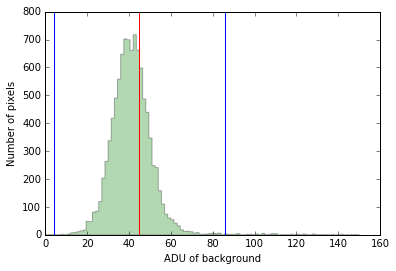

In [275]:
plt.hist(cal_snip.flatten(),bins=100,range=[0,150],histtype='stepfilled',color='g',alpha=.3)
plt.xlabel('ADU of background')
plt.ylabel('Number of pixels')
m,s=np.mean(cal_snip[cal_snip<1000]),np.std(cal_snip[cal_snip<1000])
plt.axvline(m-s),plt.axvline(m+s),plt.axvline(m,color='r')
print m,s

In [276]:
xc,yc=0,0
pixsum=0
nx,ny=np.shape(cal_snip)
for i in range(nx):
    for j in range(ny):
        if cal_snip[j,i]>6000:
            xc+=cal_snip[j,i]*i
            yc+=cal_snip[j,i]*j
            pixsum+=cal_snip[j,i]
xc,yc=xc/pixsum,yc/pixsum
print xc,yc

51.5175953146 52.4914224944


[25, 80, 30, 80]

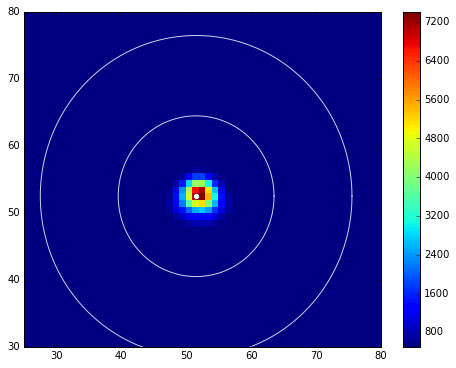

In [277]:
dr=12
r=np.arange(0,30,dr)
phi=np.linspace(0,2*np.pi,1000)


plt.figure(figsize=(8,6))
plt.pcolor(cal_snip,vmin=500)
plt.colorbar()
plt.plot(xc,yc,'wo')
for i in range(len(r)): plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'w',alpha=.8)
plt.axis([25,80,30,80])

In [278]:
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):
                ann_flux[k]+=cal_snip[j,i]
                ann_npix[k]+=1


print r,ann_flux-ann_npix*m,(ann_flux-m*ann_npix)/ann_npix


[ 0 12 24] [ 172205.36950684   -4261.31183222  -10628.94221639] [ 384.38698551   -3.13562313   -4.71141056]


In [279]:
cal_vflux=ann_flux[0]-ann_npix[0]*m
exposure=10
cal_airmass=1.285603458823
cal_mag_ext=.15*cal_airmass

print "Exposure time is: "+ str(exposure)
print "Flux is: " +str(cal_vflux)

cal_vmag=-2.5*np.log10(cal_vflux/exposure)
print "Instrumental magnitude is, -2.5*log10(flux/time): " + str(cal_vmag)

cal_mag_ext=.15*cal_airmass
print "The airmass is: " +str(cal_airmass)+", so given .15 magnitudes/airmass extinction, there are: " +str(cal_mag_ext)
print " magnitudes of extincion."

cal_vmag0=cal_vmag+cal_mag_ext
print "So our final instrum. magnitude in V, removing atmospheric effects, is: " +str(cal_vmag0)


landolt_vmag=9.036+.399
cal_vzpt=landolt_vmag-cal_vmag0
print "Landolt says SA 107-544 is magnitude 9.036, so our zeropoint is then: " +str(cal_vzpt)

Exposure time is: 10
Flux is: 172205.369507
Instrumental magnitude is, -2.5*log10(flux/time): -10.5901167225
The airmass is: 1.28560345882, so given .15 magnitudes/airmass extinction, there are: 0.192840518823
 magnitudes of extincion.
So our final instrum. magnitude in V, removing atmospheric effects, is: -10.3972762037
Landolt says SA 107-544 is magnitude 9.036, so our zeropoint is then: 19.8322762037


[490, 890, 450, 850]

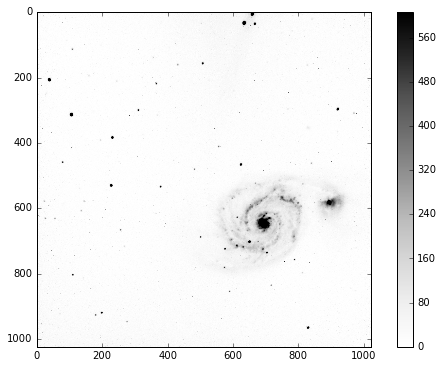

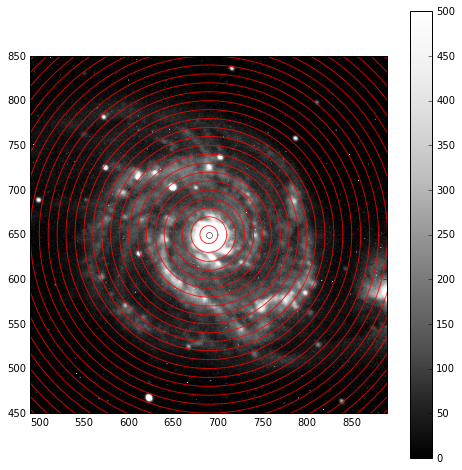

In [280]:
stackedimg=np.median(science_reduced_B,axis=0)-np.median(skylevels)
plt.figure(figsize=(9,6))
plt.imshow(stackedimg,cmap='Greys',vmin=0,vmax=20*np.sqrt(np.median(skylevels)))
plt.colorbar()

dr=10
r=np.arange(0,300,dr)
phi=np.linspace(0,2*np.pi,1000)
xc,yc=690,650

plt.figure(figsize=(8,8))
#m51_vsnip=stackedimg[500:850,400:750]
plt.imshow(stackedimg,vmin=0,vmax=.5e3,cmap='Greys_r')
plt.colorbar()

plt.plot(xc,yc,'wo')
for i in range(len(r)): plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'r',alpha=.8)
plt.axis([xc-200,xc+200,yc-200,yc+200])

7.3097751262
boobs


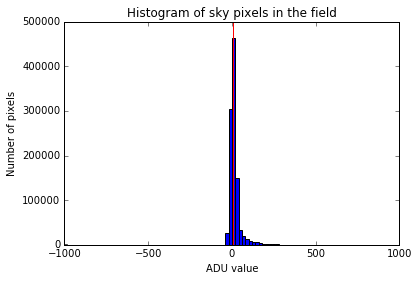

In [281]:
plt.hist(stackedimg.flatten(),range=[-1000,1000],bins=100)
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')
plt.title('Histogram of sky pixels in the field')
bkg=np.median(stackedimg)
plt.axvline(bkg,color='r')
print bkg

print"boobs"

In [282]:
nx,ny=np.shape(stackedimg)
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
# this loops over every pixel in the image (which is a rather brute force method)
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):     # if the pixel is insize the kth aperture, add it to the tally
                ann_flux[k]+=stackedimg[j,i]
                ann_npix[k]+=1


print r,ann_flux-bkg*ann_npix,(ann_flux-bkg*ann_npix)/ann_npix

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290] [ 394865.46823553  537404.29050288  400012.98857284  339373.49467255
  372108.18046568  450324.70949782  641654.16581376  567321.78544998
  589490.83519399  565268.15060698  634669.70967122  662127.91346739
  561947.02023373  392995.75512216  261636.26906555  161453.03716901
  127401.67742112  134815.02584132  146516.10707127  228196.07330323
  182768.96463516  345241.5567327   219650.91907961  174786.59492606
  150070.84713208   79088.03909645   33952.82855408   38108.01003703
   -8125.19296963  -26729.79647237] [  1.29889957e+03   5.79099451e+02   2.57740328e+02   1.54823675e+02
   1.32895779e+02   1.31213493e+02   1.57577153e+02   1.20809580e+02
   1.10144028e+02   9.49711275e+01   9.68665613e+01   9.15552978e+01
   7.18970087e+01   4.65634781e+01   2.86504894e+01   1.66652598e+01
   1.22879704e+01   1.22916690e+01   1.26394157e+01   1.86434700e+01
   1.42077864

In [283]:
m51_V_airmass=1.028792897739
pixscale=24*60/1024.
print "The pixel scale is: "+str(pixscale)+ ", airmass is: " + str(m51_V_airmass)

B_surfbright=-2.5*np.log10((ann_flux-bkg*ann_npix)/300.)+2.5*np.log10(ann_npix*pixscale**2)+cal_vzpt+.15*m51_V_airmass

The pixel scale is: 1.40625, airmass is: 1.02879289774


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


In [284]:
print v_surfbright,B_surfbright, I_surfbright

[ 18.3278331   19.35403443  20.25204675  20.74613322  20.92786326
  21.00067169  20.8646284   21.15936443  21.25499659  21.43052178
  21.4799138   21.59280063  21.87194153  22.30312721  22.74555556
  23.27080169  23.53808287  23.37305149  23.26765887  22.86702342
  22.97183606  22.27781369  22.99072138  23.31600496  23.59237362
  24.22205112  24.87567187  25.20979048  26.82899361          nan] [ 19.13577202  20.01282807  20.89175501  21.44511753  21.61093299
  21.62476471  21.42597783  21.71445752  21.81480857  21.97573197
  21.95427625  22.01550225  22.2779339   22.74959742  23.27688084
  23.86518073  24.19601056  24.19568381  24.16539346  23.74339408
  24.0383949   23.39991596  23.9448752   24.23143851  24.44607854
  25.18473389  26.14331439  26.06002384          nan          nan] [ 17.78305588  18.8630293   19.72411902  20.18954482  20.38842291
  20.49005799  20.59318841  20.66104094  20.86031804  20.97141459
  21.09944508  21.2576213   21.5676741   21.96457145  22.22933862
  22.637

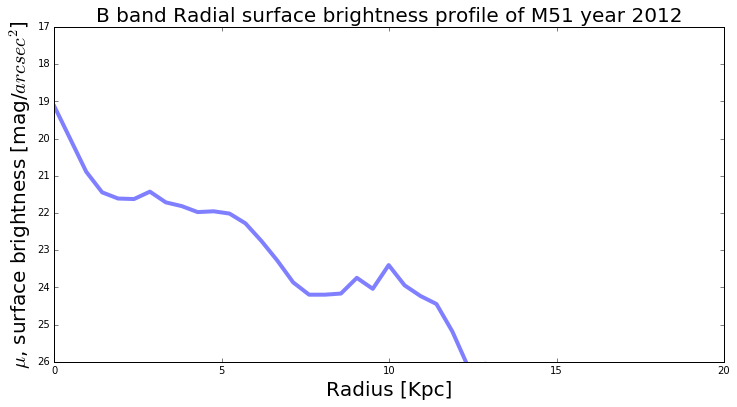

In [300]:
radius=r*pixscale*7100*(1/2.1e5)
plt.figure(figsize=(12,6))
plt.plot(radius,B_surfbright,linewidth=4,alpha=.5)
plt.axis([0,20,26,17])
plt.xlabel('Radius [Kpc]',fontsize=20)
plt.ylabel('$\\mu$, surface brightness [mag/$arcsec^2$]',fontsize=20)
plt.title('B band Radial surface brightness profile of M51 year 2012',fontsize=20)

# I band Calibration

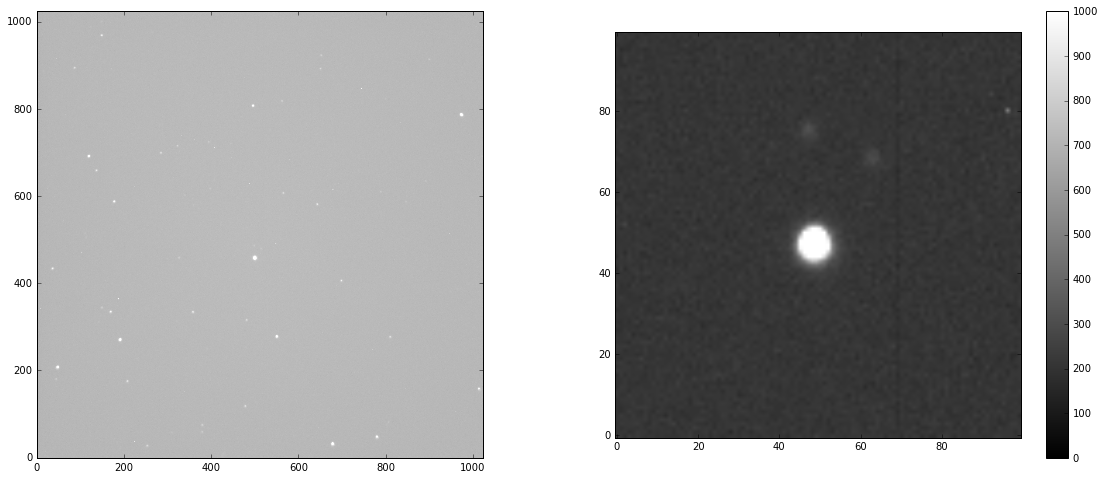

In [286]:
calibfilename_I=['/Users/noahknoblauch/PHY157/Observing/5-24-2012/5242012 Calibration 302 I/I_Band_calib.FIT']

calib_I_data=np.array(pyfits.getdata(calibfilename_I[0]))

normed_flat_calib=(medianflat_I-medianbias_524)/np.median(medianflat_I-medianbias_524)
red_calibdata_B=(calib_I_data-medianbias_524)/normed_flat_calib


plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(calib_I_data,vmin=0,vmax=2000,cmap='gray',origin='lower')
cal_snip=red_calibdata_B[410:510,450:550]
plt.subplot(122)
plt.imshow(cal_snip,vmin=0,vmax=1000,cmap='gray',origin='lower')
plt.colorbar()

215.328450991 31.3164651396


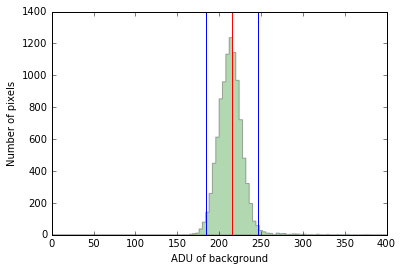

In [287]:
plt.hist(cal_snip.flatten(),bins=100,range=[0,400],histtype='stepfilled',color='g',alpha=.3)
plt.xlabel('ADU of background')
plt.ylabel('Number of pixels')
m,s=np.mean(cal_snip[cal_snip<1000]),np.std(cal_snip[cal_snip<1000])
plt.axvline(m-s),plt.axvline(m+s),plt.axvline(m,color='r')
print m,s

In [288]:
xc,yc=0,0
pixsum=0
nx,ny=np.shape(cal_snip)
for i in range(nx):
    for j in range(ny):
        if cal_snip[j,i]>6000:
            xc+=cal_snip[j,i]*i
            yc+=cal_snip[j,i]*j
            pixsum+=cal_snip[j,i]
xc,yc=xc/pixsum,yc/pixsum
print xc,yc

48.4946251304 47.9486884029


[25, 80, 30, 80]

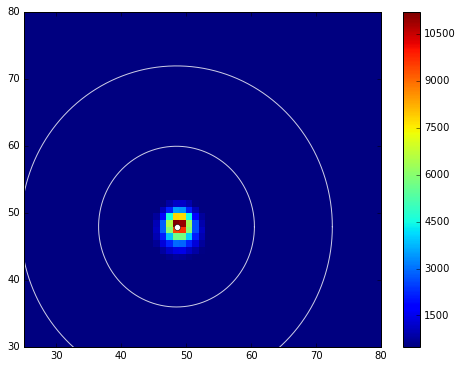

In [289]:
dr=12
r=np.arange(0,30,dr)
phi=np.linspace(0,2*np.pi,1000)


plt.figure(figsize=(8,6))
plt.pcolor(cal_snip,vmin=500)
plt.colorbar()
plt.plot(xc,yc,'wo')
for i in range(len(r)): plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'w',alpha=.8)
plt.axis([25,80,30,80])

In [290]:
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):
                ann_flux[k]+=cal_snip[j,i]
                ann_npix[k]+=1


print r,ann_flux-ann_npix*m,(ann_flux-m*ann_npix)/ann_npix

[ 0 12 24] [ 180235.57294726   -1890.2118591    -3831.23885109] [ 396.99465407   -1.39190859   -1.69224331]


In [311]:
cal_vflux=ann_flux[0]-ann_npix[0]*m
exposure=40
cal_airmass=1.285603458823
cal_mag_ext=.15*cal_airmass

print "Exposure time is: "+ str(exposure)
print "Flux is: " +str(cal_vflux)

cal_vmag=-2.5*np.log10(cal_vflux/exposure)
print "Instrumental magnitude is, -2.5*log10(flux/time): " + str(cal_vmag)

cal_mag_ext=.15*cal_airmass
print "The airmass is: " +str(cal_airmass)+", so given .15 magnitudes/airmass extinction, there are: " +str(cal_mag_ext)
print " magnitudes of extincion."

cal_vmag0=cal_vmag+cal_mag_ext
print "So our final instrum. magnitude in I, removing atmospheric effects, is: " +str(cal_vmag0)


landolt_vmag=9.859-.465
cal_vzpt=landolt_vmag-cal_vmag0
print "Landolt says SA 103-302 is magnitude 9.8302, so our zeropoint is then: " +str(cal_vzpt)

Exposure time is: 40
Flux is: 949293.248312
Instrumental magnitude is, -2.5*log10(flux/time): -10.9383510018
The airmass is: 1.28560345882, so given .15 magnitudes/airmass extinction, there are: 0.192840518823
 magnitudes of extincion.
So our final instrum. magnitude in I, removing atmospheric effects, is: -10.745510483
Landolt says SA 103-302 is magnitude 9.8302, so our zeropoint is then: 20.139510483


[550, 950, 380, 780]

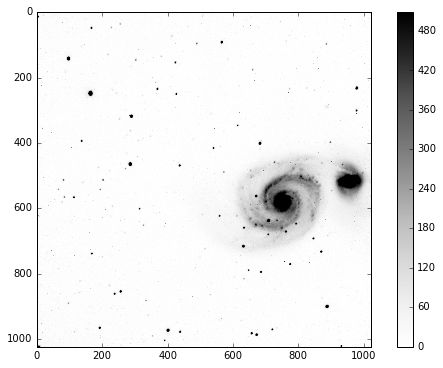

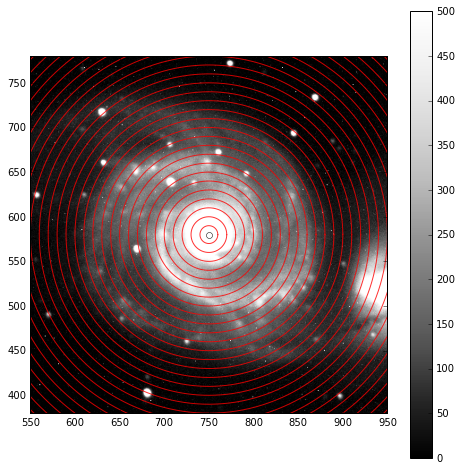

In [292]:
stackedimg=np.median(science_reduced_I,axis=0)-np.median(skylevels_I)
plt.figure(figsize=(9,6))
plt.imshow(stackedimg,cmap='Greys',vmin=0,vmax=20*np.sqrt(np.median(skylevels_I)))
plt.colorbar()

dr=10
r=np.arange(0,300,dr)
phi=np.linspace(0,2*np.pi,1000)
xc,yc=750,580

plt.figure(figsize=(8,8))
#m51_vsnip=stackedimg[500:850,400:750]
plt.imshow(stackedimg,vmin=0,vmax=.5e3,cmap='Greys_r')
plt.colorbar()

plt.plot(xc,yc,'wo')
for i in range(len(r)): plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'r',alpha=.8)
plt.axis([xc-200,xc+200,yc-200,yc+200])

3.11982613139
boobs


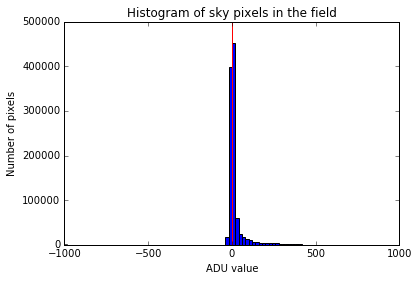

In [293]:
plt.hist(stackedimg.flatten(),range=[-1000,1000],bins=100)
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')
plt.title('Histogram of sky pixels in the field')
bkg=np.median(stackedimg)
plt.axvline(bkg,color='r')
print bkg

print"boobs"

In [294]:
nx,ny=np.shape(stackedimg)
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
# this loops over every pixel in the image (which is a rather brute force method)
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):     # if the pixel is insize the kth aperture, add it to the tally
                ann_flux[k]+=stackedimg[j,i]
                ann_npix[k]+=1


print r,ann_flux-bkg*ann_npix,(ann_flux-bkg*ann_npix)/ann_npix

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290] [ 1013804.67026889  1144561.97282207   866058.37487536   796756.61509917
   847406.75652044   945860.60606664  1020552.76312839  1105642.61225503
  1048798.23048356  1052931.56110335  1030146.30863199   982908.19230914
   798395.2869887    598159.38492235   507146.59073943   369540.00731093
   343636.50343796   434885.13093316   646572.36615081   742544.0580021
  1128186.89867213  1334938.64595553   728671.5834379    585379.05647046
   446519.31748952   282194.8129268    222973.99896338   124899.03670839
    42483.84307265     4450.73594463] [  3.33488378e+03   1.23336419e+03   5.58027303e+02   3.63483857e+02
   3.02645270e+02   2.75600410e+02   2.50626906e+02   2.35443486e+02
   1.95963795e+02   1.76903824e+02   1.57226238e+02   1.35910978e+02
   1.02148834e+02   7.08719650e+01   5.55351063e+01   3.81440965e+01
   3.31439529e+01   3.96503584e+01   5.57774643e+01  

In [295]:
m51_V_airmass=1.028792897739
pixscale=24*60/1024.
print "The pixel scale is: "+str(pixscale)+ ", airmass is: " + str(m51_V_airmass)

I_surfbright=-2.5*np.log10((ann_flux-bkg*ann_npix)/300.)+2.5*np.log10(ann_npix*pixscale**2)+cal_vzpt-.15*m51_V_airmass

The pixel scale is: 1.40625, airmass is: 1.02879289774


In [296]:
print I_surfbright

[ 17.78305588  18.8630293   19.72411902  20.18954482  20.38842291
  20.49005799  20.59318841  20.66104094  20.86031804  20.97141459
  21.09944508  21.2576213   21.5676741   21.96457145  22.22933862
  22.63718931  22.78974688  22.59513985  22.22461072  22.13340562
  21.73324509  21.60261705  22.31392486  22.59016255  22.93326543
  23.47468503  23.77091542  24.40965619  25.54993421  27.99567504]


In [297]:
#print -2.5*np.log10((np.sqrt(ann_flux-bkg*ann_npix)/300.))+2.5*np.log10(np.sqrt(ann_npix*pixscale**2))+cal_vzpt+.15*m51_V_airmass

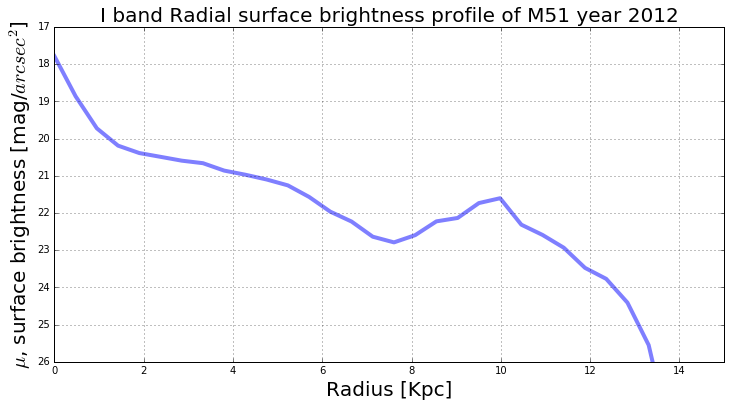

In [299]:
radius=r*pixscale*7100*(1/2.1e5)
plt.figure(figsize=(12,6))
plt.plot(radius,I_surfbright,linewidth=4,alpha=.5)
plt.axis([0,15,26,17])
plt.grid()
plt.xlabel('Radius [Kpc]',fontsize=20)
plt.ylabel('$\\mu$, surface brightness [mag/$arcsec^2$]',fontsize=20)
plt.title('I band Radial surface brightness profile of M51 year 2012',fontsize=20)

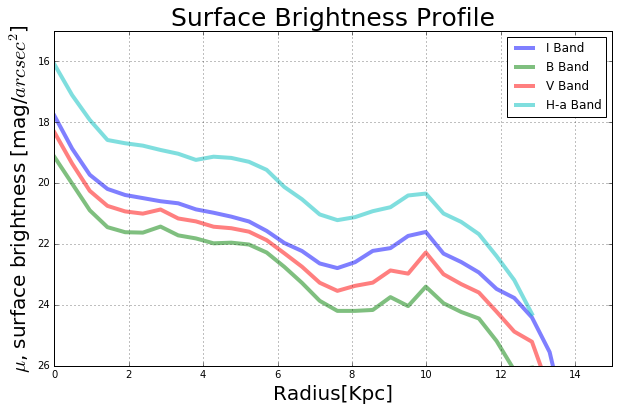

In [314]:
plt.figure(figsize=(10,6))
plt.plot(radius,I_surfbright,linewidth=4,alpha=.5,label='I Band')
plt.plot(radius,B_surfbright,linewidth=4,alpha=.5,label='B Band')
plt.plot(radius,v_surfbright,linewidth=4,alpha=.5,label='V Band')
plt.plot(radius,boobs,linewidth=4,alpha=.5,label='H-a Band')
plt.title("Surface Brightness Profile",fontsize=25)
plt.xlabel('Radius[Kpc]',fontsize=20)
plt.ylabel('$\\mu$, surface brightness [mag/$arcsec^2$]',fontsize=20)
plt.axis([0,15,26,15])
plt.legend()
plt.grid()
plt.show()

In [305]:
boobs=np.loadtxt('test1.txt')

In [306]:
print boobs

[ 16.09492973  17.10518762  17.92061628  18.58128411  18.68840365
  18.76662734  18.90863169  19.0328743   19.23557905  19.12975304
  19.16923871  19.29762114  19.56215841  20.12488468  20.52925834
  21.02688329  21.21433865  21.11589902  20.92034239  20.78948575
  20.40391723  20.34149115  20.99622078  21.27153062  21.67432631
  22.39727825  23.18365866  24.29581706          nan          nan]
